In [1]:
# Cell 0 — Diagnostics
import os, sys, pickle, numpy as np
import tensorflow as tf

print("Python:", sys.version.splitlines()[0])
print("TensorFlow:", tf.__version__)
print("Physical GPUs:", tf.config.list_physical_devices('GPU'))
print("CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES", "<not set>"))

# Work folder used for saves (change if needed)
WORK = r"D:\Infosys_AI-Tracefinder\Notebooks"
OUTPUT_DIR = r"D:\Infosys_AI-Tracefinder\Output"
os.makedirs(WORK, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("WORK:", WORK)
print("OUTPUT_DIR:", OUTPUT_DIR)


Python: 3.13.7 (tags/v3.13.7:bcee1c3, Aug 14 2025, 14:15:11) [MSC v.1944 64 bit (AMD64)]
TensorFlow: 2.20.0
Physical GPUs: []
CUDA_VISIBLE_DEVICES: <not set>
WORK: D:\Infosys_AI-Tracefinder\Notebooks
OUTPUT_DIR: D:\Infosys_AI-Tracefinder\Output


In [15]:
# Cell 1 — Imports & config
import os, math, pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import cv2
import pywt
from scipy.stats import skew, kurtosis
from skimage.feature import local_binary_pattern
from scipy.fft import fft2, fftshift

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Paths (edit if needed)
DATA_ROOT    = r"D:\Infosys_AI-Tracefinder\Data"
OFFICIAL_DIR = os.path.join(DATA_ROOT, "Official")
FLATFIELD_DIR= os.path.join(DATA_ROOT, "Flatfield")
WIKI_DIR     = os.path.join(DATA_ROOT, "Wikipedia")

WORK         = r"D:\Infosys_AI-Tracefinder\Notebooks"  # where outputs / models are saved
OUTPUT_DIR   = r"D:\Infosys_AI-Tracefinder\Output"     # CSVs / pickles

os.makedirs(WORK, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

IMG_SIZE = (256,256)   # residual image size

# Training-config (CPU friendly)
BATCH = 32        # small batch for CPU; increase if you have GPU
EPOCHS = 64      # ceiling (EarlyStopping used)
LEARNING_RATE = 1e-3
RANDOM_STATE = 42

np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print("Paths:")
print(" OFFICIAL:", OFFICIAL_DIR)
print(" FLATFIELD:", FLATFIELD_DIR)
print(" WIKI:", WIKI_DIR)
print(" WORK:", WORK)
print(" OUTPUT:", OUTPUT_DIR)
print("TensorFlow:", tf.__version__)
print("BATCH, EPOCHS, LR:", BATCH, EPOCHS, LEARNING_RATE)


Paths:
 OFFICIAL: D:\Infosys_AI-Tracefinder\Data\Official
 FLATFIELD: D:\Infosys_AI-Tracefinder\Data\Flatfield
 WIKI: D:\Infosys_AI-Tracefinder\Data\Wikipedia
 WORK: D:\Infosys_AI-Tracefinder\Notebooks
 OUTPUT: D:\Infosys_AI-Tracefinder\Output
TensorFlow: 2.20.0
BATCH, EPOCHS, LR: 32 64 0.001


In [3]:
# Cell 2 — Image helpers & residual extraction
def to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img is not None and img.ndim == 3 else img

def resize_to(img, size=IMG_SIZE):
    return cv2.resize(img, size, interpolation=cv2.INTER_AREA)

def normalize_img(img):
    im = img.astype(np.float32)
    maxv = im.max() if im.max() > 0 else 1.0
    return im / maxv

def denoise_wavelet(img):
    coeffs = pywt.dwt2(img, "haar")
    cA, (cH, cV, cD) = coeffs
    cH[:] = 0; cV[:] = 0; cD[:] = 0
    rec = pywt.idwt2((cA, (cH, cV, cD)), 'haar')
    # if shapes differ, resize to original shape
    if rec.shape != img.shape:
        rec = resize_to(rec, img.shape[::-1]) if img.ndim==2 else resize_to(rec, (img.shape[1], img.shape[0]))
    return rec

def compute_residual_from_tiff(path):
    """
    Returns residual array shape (H,W) float32 normalized (-1..1 approx)
    Raises RuntimeError if image not readable.
    """
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise RuntimeError(f"Unreadable image: {path}")
    g = to_gray(img)
    if g is None:
        raise RuntimeError(f"Cannot convert to gray: {path}")
    g = resize_to(g, IMG_SIZE)
    g = normalize_img(g)
    den = denoise_wavelet(g)
    res = (g - den).astype(np.float32)
    m = np.max(np.abs(res)) if np.max(np.abs(res)) > 0 else 1.0
    return (res / m).astype(np.float32)


In [4]:
# Cell 3 — Dataset scanner (handles both structures)
def process_dataset(base_dir, dataset_name="dataset"):
    result = {}
    if not os.path.exists(base_dir):
        print(f"[WARN] dataset folder not found: {base_dir}")
        return result

    scanners = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir,d))])
    print(f"\nScanning dataset '{dataset_name}' at: {base_dir}  (scanners: {len(scanners)})")
    for scanner in tqdm(scanners, desc=f"{dataset_name} scanners"):
        scanner_path = os.path.join(base_dir, scanner)
        if not os.path.isdir(scanner_path):
            continue
        # detect DPI subfolders
        subdirs = [d for d in os.listdir(scanner_path) if os.path.isdir(os.path.join(scanner_path, d))]
        residuals = []
        if subdirs:
            # structure: scanner/dpi/*.tif
            for dpi in subdirs:
                dpi_path = os.path.join(scanner_path, dpi)
                if not os.path.isdir(dpi_path):
                    continue
                files = [os.path.join(dpi_path, f) for f in os.listdir(dpi_path)
                         if f.lower().endswith((".tif", ".tiff")) and not f.startswith("._")]
                for fpath in files:
                    try:
                        res = compute_residual_from_tiff(fpath)
                        residuals.append(res)
                    except Exception as e:
                        # keep going, but you can log
                        # print("SKIP:", fpath, "->", e)
                        continue
        else:
            # structure: scanner/*.tif (flatfield)
            files = [os.path.join(scanner_path, f) for f in os.listdir(scanner_path)
                     if f.lower().endswith((".tif", ".tiff")) and not f.startswith("._")]
            for fpath in files:
                try:
                    res = compute_residual_from_tiff(fpath)
                    residuals.append(res)
                except Exception as e:
                    # print("SKIP:", fpath, "->", e)
                    continue
        result[scanner] = residuals
    return result

# Run scans
print("Processing Official ...")
res_official = process_dataset(OFFICIAL_DIR, "Official")

print("\nProcessing Wikipedia ...")
res_wiki = process_dataset(WIKI_DIR, "Wikipedia")

print("\nProcessing Flatfield ...")
res_flatfield = process_dataset(FLATFIELD_DIR, "Flatfield")


Processing Official ...

Scanning dataset 'Official' at: D:\Infosys_AI-Tracefinder\Data\Official  (scanners: 11)


Official scanners: 100%|██████████| 11/11 [02:53<00:00, 15.77s/it]



Processing Wikipedia ...

Scanning dataset 'Wikipedia' at: D:\Infosys_AI-Tracefinder\Data\Wikipedia  (scanners: 11)


Wikipedia scanners: 100%|██████████| 11/11 [04:30<00:00, 24.58s/it]



Processing Flatfield ...

Scanning dataset 'Flatfield' at: D:\Infosys_AI-Tracefinder\Data\Flatfield  (scanners: 11)


Flatfield scanners: 100%|██████████| 11/11 [00:03<00:00,  3.57it/s]


In [5]:
# Cell 4 — Summaries & save flatfield residuals
def summarize_dict(d, name):
    total = sum(len(v) for v in d.values())
    print(f"\nSummary: {name}  (scanners: {len(d)}, total residuals: {total})")
    for k in sorted(d.keys()):
        print("  ", k, "->", len(d[k]))

summarize_dict(res_official, "Official")
summarize_dict(res_wiki, "Wikipedia")
summarize_dict(res_flatfield, "Flatfield")

# Save flatfield residuals for reuse
flatfield_pkl = os.path.join(WORK, "flatfield_residuals.pkl")   # saved to WORK
with open(flatfield_pkl, "wb") as f:
    pickle.dump(res_flatfield, f)
print("\nSaved flatfield residuals ->", flatfield_pkl)



Summary: Official  (scanners: 11, total residuals: 2200)
   Canon120-1 -> 200
   Canon120-2 -> 200
   Canon220 -> 200
   Canon9000-1 -> 200
   Canon9000-2 -> 200
   EpsonV370-1 -> 200
   EpsonV370-2 -> 200
   EpsonV39-1 -> 200
   EpsonV39-2 -> 200
   EpsonV550 -> 200
   HP -> 200

Summary: Wikipedia  (scanners: 11, total residuals: 2367)
   Canon120-1 -> 216
   Canon120-2 -> 216
   Canon220 -> 216
   Canon9000-1 -> 216
   Canon9000-2 -> 207
   EpsonV370-1 -> 216
   EpsonV370-2 -> 216
   EpsonV39-1 -> 216
   EpsonV39-2 -> 216
   EpsonV550 -> 216
   HP -> 216

Summary: Flatfield  (scanners: 11, total residuals: 22)
   Canon120-1 -> 2
   Canon120-2 -> 2
   Canon220 -> 2
   Canon9000-1 -> 2
   Canon9000-2 -> 2
   EpsonV370-1 -> 2
   EpsonV370-2 -> 2
   EpsonV39-1 -> 2
   EpsonV39-2 -> 2
   EpsonV550 -> 2
   HP -> 2

Saved flatfield residuals -> D:\Infosys_AI-Tracefinder\Notebooks\flatfield_residuals.pkl


In [6]:
# Cell 5 — fingerprints (mean of flatfield residuals)
FP_OUT = os.path.join(WORK, "scanner_fingerprints.pkl")
FP_KEYS = os.path.join(WORK, "fp_keys.npy")

scanner_fps = {}
for scanner, res_list in res_flatfield.items():
    if not res_list:
        # no flatfield images -> zeros fingerprint
        print("Warning: no flatfield for", scanner, "- using zero fingerprint")
        scanner_fps[scanner] = np.zeros(IMG_SIZE, dtype=np.float32)
        continue
    stack = np.stack(res_list, axis=0)  # (N, H, W)
    scanner_fps[scanner] = np.mean(stack, axis=0).astype(np.float32)

with open(FP_OUT, "wb") as f:
    pickle.dump(scanner_fps, f)
np.save(FP_KEYS, np.array(sorted(scanner_fps.keys())))
print("Saved fingerprints:", FP_OUT)
print("Saved fp keys:", FP_KEYS)


Saved fingerprints: D:\Infosys_AI-Tracefinder\Notebooks\scanner_fingerprints.pkl
Saved fp keys: D:\Infosys_AI-Tracefinder\Notebooks\fp_keys.npy


In [7]:
# Cell 6 — Merge residuals and extract features
# Merge dictionaries: official then wiki
combined_residuals = {}
all_scanners = sorted(set(list(res_official.keys()) + list(res_wiki.keys())))
for sc in all_scanners:
    list_off = res_official.get(sc, [])
    list_w   = res_wiki.get(sc, [])
    combined_residuals[sc] = list_off + list_w

print("Merged scanners count:", len(combined_residuals))

# feature helper functions
def corr2d(a, b):
    a = a.ravel().astype(np.float32); b = b.ravel().astype(np.float32)
    a -= a.mean(); b -= b.mean()
    denom = np.linalg.norm(a)*np.linalg.norm(b)
    return float((a @ b) / denom) if denom > 0 else 0.0

def fft_radial_energy(img, K=6):
    f = fftshift(fft2(img)); mag = np.abs(f)
    h,w = mag.shape; cy, cx = h//2, w//2
    yy, xx = np.ogrid[:h, :w]
    r = np.sqrt((yy-cy)**2 + (xx-cx)**2)
    bins = np.linspace(0, r.max()+1e-6, K+1)
    feats = []
    for i in range(K):
        mask = (r >= bins[i]) & (r < bins[i+1])
        feats.append(float(np.mean(mag[mask])) if np.any(mask) else 0.0)
    return feats

def lbp_hist_safe(img, P=8, R=1.0):
    rng = float(np.ptp(img))
    if rng < 1e-12:
        return [0.0] * (P+2)
    g = (img - img.min()) / (rng + 1e-8)
    g8 = (g*255).astype(np.uint8)
    codes = local_binary_pattern(g8, P, R, method="uniform")
    hist, _ = np.histogram(codes, bins=np.arange(P+3), density=True)
    return hist.astype(np.float32).tolist()

# prepare fingerprint keys in consistent order
fp_keys = sorted(scanner_fps.keys())

features = []
labels = []
X_img_list = []

for sc in tqdm(sorted(combined_residuals.keys()), desc="Extract features"):
    res_list = combined_residuals[sc]
    for res in res_list:
        v_corr = [corr2d(res, scanner_fps[k]) for k in fp_keys]
        v_fft = fft_radial_energy(res, K=6)
        v_lbp = lbp_hist_safe(res, P=8, R=1.0)
        feat_vec = v_corr + v_fft + v_lbp
        features.append(feat_vec)
        labels.append(sc)
        X_img_list.append(res[..., None])  # (H,W,1)

X_feat = np.array(features, dtype=np.float32)
X_img  = np.array(X_img_list, dtype=np.float32)
y_raw  = np.array(labels, dtype=object)

print("Prepared shapes -> X_img:", X_img.shape, "X_feat:", X_feat.shape, "y:", y_raw.shape)

# Encode & scale
le = LabelEncoder()
y = le.fit_transform(y_raw)
scaler = StandardScaler()
X_feat_scaled = scaler.fit_transform(X_feat)

# Save datasets & preprocessors to WORK (Notebooks)
np.save(os.path.join(WORK, "X_img.npy"), X_img)
np.save(os.path.join(WORK, "X_feat.npy"), X_feat_scaled)
np.save(os.path.join(WORK, "y.npy"), y)

with open(os.path.join(WORK, "hybrid_label_encoder.pkl"), "wb") as f:
    pickle.dump(le, f)
with open(os.path.join(WORK, "hybrid_feat_scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)
with open(os.path.join(WORK, "scanner_fingerprints.pkl"), "wb") as f:
    pickle.dump(scanner_fps, f)
np.save(os.path.join(WORK, "fp_keys.npy"), np.array(fp_keys))

print("Saved X_img, X_feat, y, label encoder, scaler, fingerprints to WORK")
print("Classes:", list(le.classes_))
print("Feature vector length:", X_feat.shape[1])


Merged scanners count: 11


Extract features: 100%|██████████| 11/11 [01:05<00:00,  6.00s/it]


Prepared shapes -> X_img: (4567, 256, 256, 1) X_feat: (4567, 27) y: (4567,)
Saved X_img, X_feat, y, label encoder, scaler, fingerprints to WORK
Classes: ['Canon120-1', 'Canon120-2', 'Canon220', 'Canon9000-1', 'Canon9000-2', 'EpsonV370-1', 'EpsonV370-2', 'EpsonV39-1', 'EpsonV39-2', 'EpsonV550', 'HP']
Feature vector length: 27


In [8]:
# Cell 7 — Build CPU-friendly Hybrid CNN
IMG_SHAPE = X_img.shape[1:]   # e.g. (256,256,1)
FEAT_DIM  = X_feat.shape[1]
num_classes = len(le.classes_)

img_in  = keras.Input(shape=IMG_SHAPE, name="residual", dtype="float32")
feat_in = keras.Input(shape=(FEAT_DIM,), name="handcrafted", dtype="float32")

# small high-pass kernel layer (fixed)
hp_kernel = np.array([[-1,-1,-1], [-1,8,-1], [-1,-1,-1]], dtype=np.float32).reshape((3,3,1,1))
hp_layer = layers.Conv2D(1, (3,3), padding="same", use_bias=False, trainable=False, name="hp_filter")
hp_layer.build((None,) + IMG_SHAPE)
hp_layer.set_weights([hp_kernel])
hp = hp_layer(img_in)

# Reduced CNN branch (16/32/64)
x = layers.Conv2D(16, (3,3), activation="relu", padding="same")(hp)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.15)(x)

x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.15)(x)

x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
x = layers.GlobalAveragePooling2D()(x)

# Handcrafted branch
f = layers.Dense(32, activation="relu")(feat_in)
f = layers.Dropout(0.2)(f)

# Fusion
z = layers.Concatenate()([x, f])
z = layers.Dense(128, activation="relu")(z)
z = layers.Dropout(0.25)(z)
out = layers.Dense(num_classes, activation="softmax", dtype="float32", name="predictions")(z)

model = keras.Model(inputs=[img_in, feat_in], outputs=out)

opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ residual            │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hp_filter (Conv2D)  │ (None, 256, 256,  │          9 │ residual[0][0]    │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        160 │ hp_filter[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      4,640 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ handcrafted         │ (None, 27)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ dropout_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        896 │ handcrafted[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv2d_2[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     12,416 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ predictions (Dense) │ (None, 11)        │      1,419 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,036 (148.58 KB)

 Trainable params: 38,027 (148.54 KB)

 Non-trainable params: 9 (36.00 B)

In [16]:
# Cell 8 — Train hybrid model (tf.data pipeline + callbacks + evaluation)
# Train/val split
X_img_tr, X_img_te, X_feat_tr, X_feat_te, y_tr, y_te = train_test_split(
    X_img, X_feat_scaled, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

num_classes = len(le.classes_)
y_tr_cat = keras.utils.to_categorical(y_tr, num_classes)
y_te_cat = keras.utils.to_categorical(y_te, num_classes)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.data.Dataset.from_tensor_slices(((X_img_tr, X_feat_tr), y_tr_cat)) \
    .shuffle(buffer_size=len(y_tr)) \
    .batch(BATCH).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(((X_img_te, X_feat_te), y_te_cat)) \
    .batch(BATCH).prefetch(AUTOTUNE)

# callbacks & checkpoint files in WORK
CKPT = os.path.join(WORK, "scanner_hybrid_best.keras")
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=4, min_lr=1e-6),
    keras.callbacks.ModelCheckpoint(CKPT, save_best_only=True, monitor="val_accuracy")
]

print("Training on:", X_img_tr.shape[0], "samples; batch_size:", BATCH)

history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks, verbose=2)

# Save final model + history (WORK)
MODEL_OUT = os.path.join(WORK, "scanner_hybrid_final.keras")
HIST_OUT  = os.path.join(WORK, "hybrid_training_history.pkl")
model.save(MODEL_OUT)
with open(HIST_OUT, "wb") as f:
    pickle.dump(history.history, f)

print("Saved model:", MODEL_OUT)
print("Saved history:", HIST_OUT)


Training on: 3653 samples; batch_size: 32
Epoch 1/64
115/115 - 30s - 263ms/step - accuracy: 0.9176 - loss: 0.2034 - val_accuracy: 0.9026 - val_loss: 0.2494 - learning_rate: 2.5000e-04
Epoch 2/64
115/115 - 29s - 250ms/step - accuracy: 0.9220 - loss: 0.1974 - val_accuracy: 0.8917 - val_loss: 0.2571 - learning_rate: 2.5000e-04
Epoch 3/64
115/115 - 29s - 249ms/step - accuracy: 0.9217 - loss: 0.2002 - val_accuracy: 0.9004 - val_loss: 0.2599 - learning_rate: 2.5000e-04
Epoch 4/64
115/115 - 29s - 248ms/step - accuracy: 0.9181 - loss: 0.2006 - val_accuracy: 0.9092 - val_loss: 0.2400 - learning_rate: 2.5000e-04
Epoch 5/64
115/115 - 29s - 251ms/step - accuracy: 0.9212 - loss: 0.1940 - val_accuracy: 0.9070 - val_loss: 0.2511 - learning_rate: 2.5000e-04
Epoch 6/64
115/115 - 29s - 252ms/step - accuracy: 0.9171 - loss: 0.1988 - val_accuracy: 0.8993 - val_loss: 0.2558 - learning_rate: 2.5000e-04
Epoch 7/64
115/115 - 29s - 250ms/step - accuracy: 0.9266 - loss: 0.1928 - val_accuracy: 0.9103 - val_loss:

Validation accuracy: 0.9146608315098468

Classification report:
              precision    recall  f1-score   support

  Canon120-1       0.88      0.84      0.86        83
  Canon120-2       0.85      0.80      0.82        83
    Canon220       0.94      0.95      0.95        83
 Canon9000-1       0.94      0.90      0.92        84
 Canon9000-2       0.91      0.94      0.92        82
 EpsonV370-1       0.94      0.98      0.96        83
 EpsonV370-2       0.97      0.94      0.96        83
  EpsonV39-1       0.79      0.98      0.87        84
  EpsonV39-2       0.87      0.73      0.80        83
   EpsonV550       1.00      1.00      1.00        83
          HP       1.00      1.00      1.00        83

    accuracy                           0.91       914
   macro avg       0.92      0.91      0.91       914
weighted avg       0.92      0.91      0.91       914



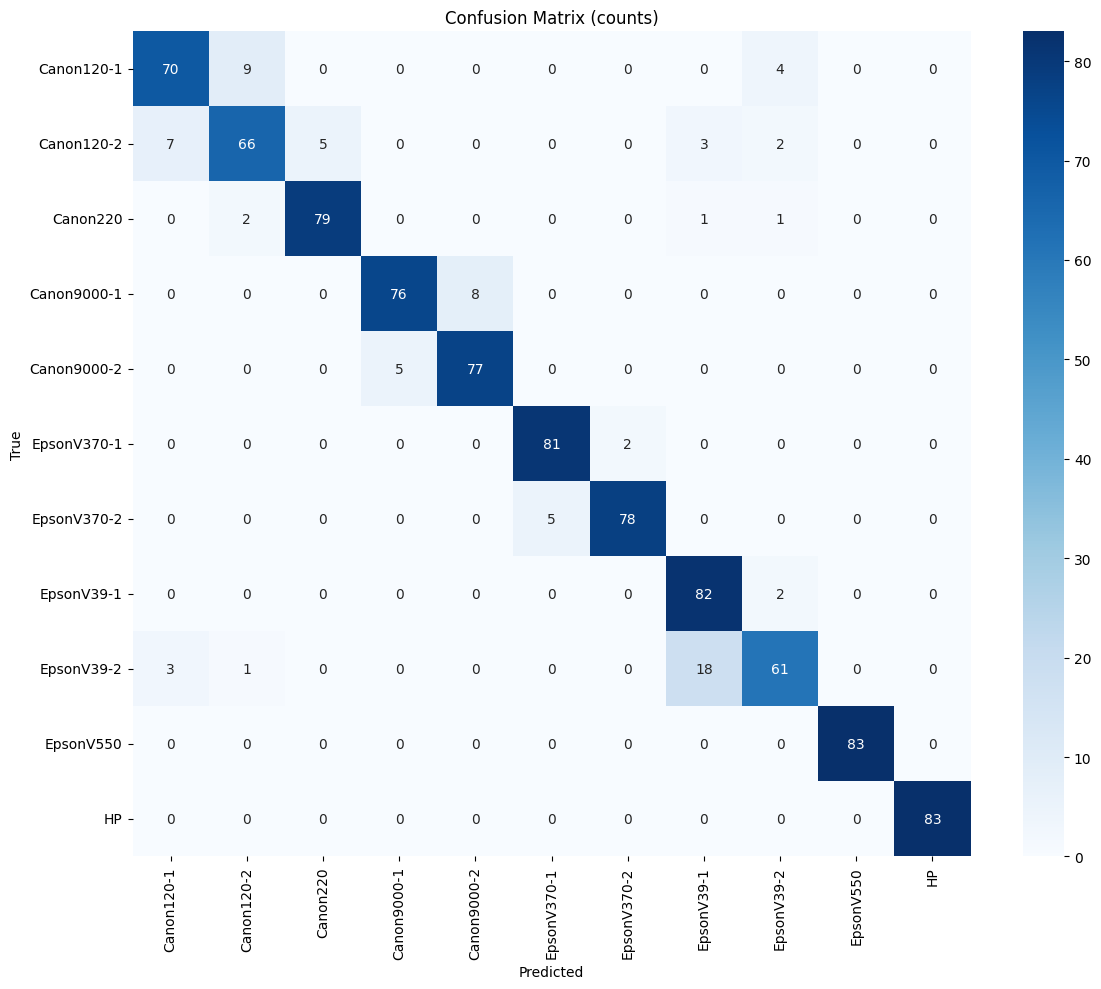

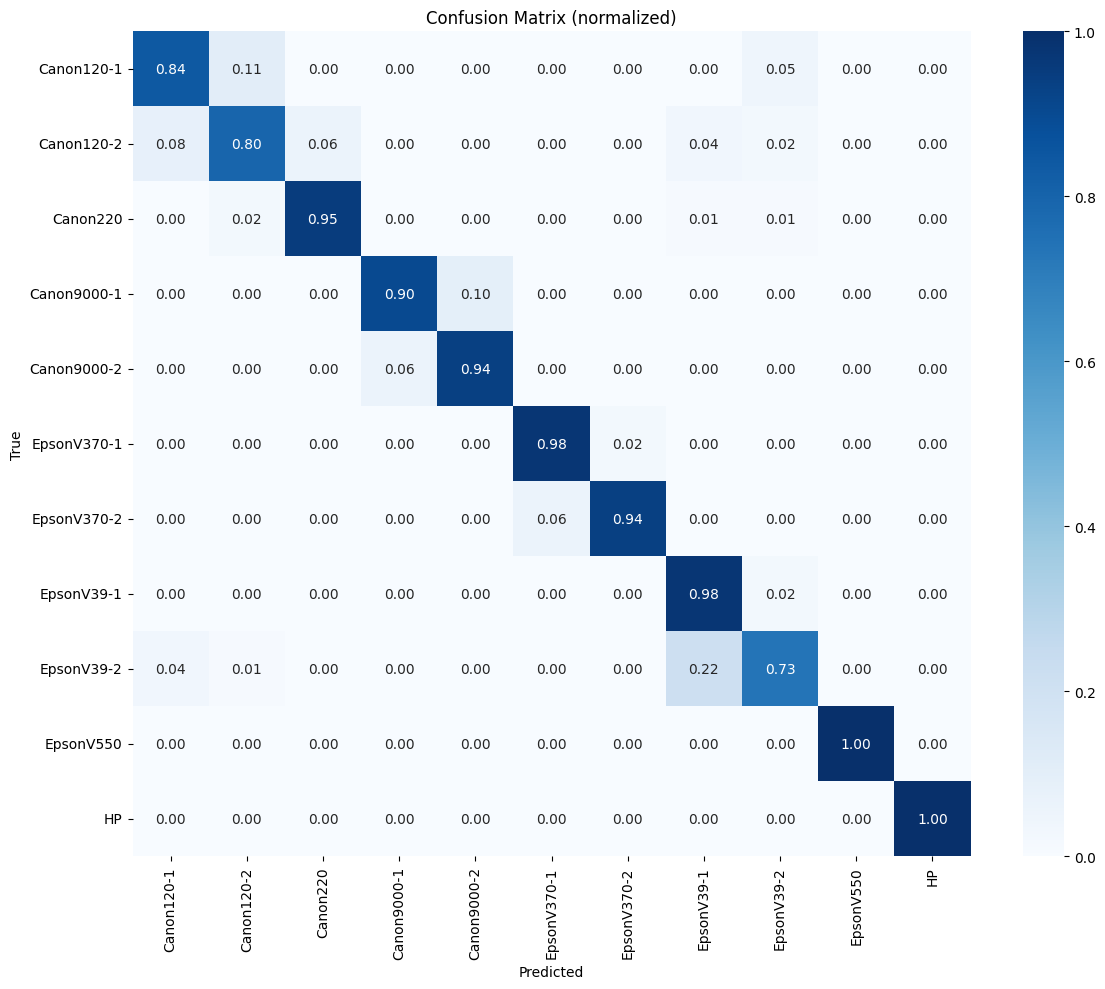

In [17]:
# Cell 9 — Evaluation & confusion matrices
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Get predictions on validation set
test_ds = tf.data.Dataset.from_tensor_slices(((X_img_te, X_feat_te), y_te_cat)).batch(BATCH)
probs = model.predict(test_ds, verbose=0)
pred_idx = np.argmax(probs, axis=1)
true_idx = y_te

acc = accuracy_score(true_idx, pred_idx)
print("Validation accuracy:", acc)
print("\nClassification report:")
print(classification_report(true_idx, pred_idx, target_names=list(le.classes_), zero_division=0))

# Raw CM
cm = confusion_matrix(true_idx, pred_idx)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Confusion Matrix (counts)")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.show()

# Normalized CM (per-row)
cm_norm = (cm.astype(np.float32) / (cm.sum(axis=1, keepdims=True)+1e-12))
plt.figure(figsize=(12,10))
sns.heatmap(cm_norm, annot=True, fmt=".2f", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Confusion Matrix (normalized)")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.show()


In [19]:
# Cell 10 — Save metadata for inference (optional)
meta = {
    "classes": list(map(str, le.classes_)),
    "feature_columns_count": X_feat.shape[1],
    "n_samples": X_img.shape[0]
}
meta_path = os.path.join(WORK, "hybrid_metadata.pkl")
with open(meta_path, "wb") as f:
    pickle.dump(meta, f)
print("Saved hybrid metadata:", meta_path)


Saved hybrid metadata: D:\Infosys_AI-Tracefinder\Notebooks\hybrid_metadata.pkl
